# Intronic variation - computational benchmark

This notebook refers to a comprehensive analysis of the prediction tools performance on variants that affect RNA Splicing. We spent a great ammount of time gathering and curating a dataset of pathogenic intronic variation located outside of canonical splice sites. Additionally, we carefully collected non-redundant variants from multiple recent studies that were shown to affect splicing outcome. Particularly, we were able to generate valuable subsets of variants that affect splicing differently (e.g. creating cryptic splice sites, affecting splicing regulatory elements, strenghning of existing cryptic sites, branchpoint disruption, etc). 

 After dataset collecion and running of the tools (most of them annotated using existing pre-computed scores), most of the analysis were performed with [VETA](https://github.com/PedroBarbosa/VETA), a simple standalone tool designed to benchmark prediction tools from VCF files. VETA's single requirement is that it just accepts VCFs annotated with [Ensembl VEP](https://www.ensembl.org/info/docs/tools/vep/script/index.html), because the `CSQ` INFO field is used to extract additional information about the variants being evaluated. 

In [16]:
#! pip install wand

In [2]:
import os
import shlex
import subprocess
from wand.image import Image as WImage
os.makedirs("out", exist_ok=True)

## **Clinvar v202204**

### *Data processing* 

##### *(initial data processing for reference. All commands are commented because the processed final files are already in the repository, and the numbers in the text description may be slightly changed, due to further refinements)* 

After annotating Clinvar with Ensembl VEP (Consequences in `CSQ` field automatically picked and filtered with `--per_gene --pick_order ccds,canonical,biotype,rank --no_intergenic --gencode_basic'`), we selected SNVs with any `intronic` consequence ocurring in protein coding genes and with Pathogenic/Likely pathogenic or Benign/Likely benign classifications. From there, we filtered those variants that are also exonic in any other transcript structure, so that at the end we keep only variants that are unequivocally intronic.

In [18]:
# Variants with any intronic consequence
#! bcftools view -v snps clinvar_annotated.vcf.gz | filter_vep --only_matched --filter '(BIOTYPE is protein_coding and HGVSc and INTRON) and (CLNSIG is Pathogenic or CLNSIG is Likely_pathogenic or CLNSIG is Pathogenic/Likely_pathogenic or CLNSIG is Benign or CLNSIG is Likely_benign or CLNSIG is Benign/Likely_benign)' | bgzip > clinvar_any_intronic_conseq_snvs.vcf.gz

# From any intronic, get those that have any exonic consequence and remove those
#! bcftools isec isec_to_get_exonic -p isec_to_get_exonic clinvar_annotated.vcf.gz clinvar_any_intronic_conseq_snvs.vcf.gz 
#! cat isec_to_get_exonic/0002.vcf | filter_vep --only_matched --filter 'EXON' | bgzip > any_exonic.vcf.gz
#! bcftools isec -p to_get_non_exonic clinvar_any_intronic_conseq_snvs.vcf.gz any_exonic.vcf.gz && mv to_get_non_exonic/0000.vcf to_get_non_exonic/non_exonic.vcf && bgzip to_get_non_exonic/non_exonic.vcf

# Non_exonic still contains many 'downstream_gene_variant', 'upstream_gene_variant', 'TF_binding_site_variant' and 'regulatory_region_variant'.
# filter_vep --only_matched --filter 'Consequence is TF_binding_site_variant or Consequence is regulatory_region_variant or Consequence is upstream_gene_variant or Consequence is downstream_gene_variant' --input to_get_non_exonic/non_exonic.vcf.gz | bgzip > no_gene_body.vcf.gz
# filter_vep --only_matched --filter 'Consequence != TF_binding_site_variant and Consequence != regulatory_region_variant and Consequence != upstream_gene_variant and Consequence != downstream_gene_variant' --input to_get_non_exonic/non_exonic.vcf.gz | bgzip > in_gene_body.vcf.gz

# From the no_gene_body set, select only those variants that are annotated in Clinvar (MC) with intronic ontology terms (filter_vep and bcftools filter had issues filtering this field)
#! zcat no_gene_body.vcf.gz | grep -v "^#" | grep -w -e 'MC=SO:0001574|splice_acceptor_variant' -e 'MC=SO:0001627|intron_variant' -e 'MC=SO:0001575|splice_donor_variant' | grep -v -e "SO:0001583|missense_variant" -e "SO:0001819|synonymous_variant" -e "SO:0001587|nonsense" -e "SO:0001582|initiatior_codon_variant" -e "SO:0001578|stop_lost" > no_gene_body_intronic_in_MC_field.vcf
# bcftools view -h no_gene_body.vcf.gz > h && cat h no_gene_body_intronic_in_MC_field.vcf | bgzip > no_gene_body_intronic_in_MC_field.vcf.gz && rm no_gene_body_intronic_in_MC_field.vcf

# From the in_gene_body set, we will remove those that have no_gene_body consequences
# bcftools isec -p in_gene_body_only in_gene_body.vcf.gz no_gene_body_intronic_in_MC_field.vcf.gz && mv in_gene_body_only/0000.vcf in_gene_body_only/in_gene_body_only.vcf

# From the no_gene_body intronic set that , we will select the pathogenic variant or those with any splice-related consequence . 
# filter_vep --input in_gene_body_only/0002.vcf --filter 'CLNSIG match athogenic or Consequence matches splice' | bgzip > no_gene_body_intronic_splicing.vcf.gz

# Variant to join to get the final set
# in_gene_body_only.vcf.gz - Variants occurring inequivocally in introns (outside gene body and variants with exon consequences are out)
# no_gene_body_intronic_splicing.vcf.gz - Pathogenic variants and splice-related variants (including benign) that were annotated with consequences outside of gene body (besides intronic ones) and that have intronic-associated MC field in original Clinvar 
# ! bcftools concat -a in_gene_body_only.vcf.gz no_gene_body_intronic_splicing.vcf.gz | bcftools norm -d none | bgzip > to_keep.vcf.gz
# filter_vep --only_matched --filter '(BIOTYPE is protein_coding and HGVSc and INTRON)' --input to_keep.vcf.gz | bgzip > clinvar_intronic_snvs.vcf.gz


Given the disproportionally large number of benign vs pathogenic variants (109,605 vs 22,005 respectively), we additionally filtered benign variants so that all high-quality benign/likely benign variants were kept, by selecting records with two or more stars. The output of this step kept 13,093 variants.

In [19]:
#! filter_vep --only_matched --input clinvar_intronic_snvs.vcf.gz --filter '(CLNSIG match enign) and (CLNREVSTAT is criteria_provided,_multiple_submitters,_no_conflicts or CLNREVSTAT is reviewed_by_expert_panel or CLNREVSTAT is practice_guideline)' | bgzip > clinvar_benign_2s.vcf.gz

To avoid being to conservative (right now benign set (N=13,093) was actually smaller than the pathogenic one (N=22,005)), we selected variants with 1 star and `Benign` classifications (N=46,166). To avoid the dataset to be excessively unbalanced we randomly selected 36,907 variants, which summed up to the high-confident 2 star set (N=13,093) ammounts to exactly 50k variants. This final number of benign variants approximately doubles the size of the pathogenic one. 

In [20]:
#! filter_vep --only_matched --input clinvar_intronic_snvs.vcf.gz --filter '(CLNSIG is Benign) and (CLNREVSTAT is criteria_provided,_single_submitter)' | bgzip > clinvar_benign_1s.vcf.gz
#! zcat clinvar_benign_1s.vcf.gz | grep -v "^#" | shuf -n 36907 | bgzip > clinvar_benign_1s_subset.vcf.gz
#! zcat clinvar_benign_2s.vcf.gz clinvar_benign_1s_subset.vcf.gz | bcftools sort -Oz -o clinvar_benign_50k.vcf.gz && tabix -pvcf clinvar_benign_50k.vcf.gz

We now select all the pathogenic variants (N=22,005) and concatenate them with the benign set (N=50,000), so that this new Clinvar intronic dataset can be evaluated by VETA (N=72,005). 

In [21]:
#! filter_vep --only_matched --input clinvar_intronic_snvs.vcf.gz --filter 'CLNSIG match athogenic' | bgzip > clinvar_pathogenic.vcf.gz && tabix -pvcf clinvar_pathogenic.vcf.gz
#! bcftools concat -a clinvar_benign_50k.vcf.gz clinvar_pathogenic.vcf.gz | bcftools sort | bgzip > clinvar_to_VETA_evaluation.vcf.gz && tabix -pvcf clinvar_to_VETA_evaluation.vcf.gz

### *VETA evaluation*

#### *Analysis of Figure 1, Supplementary Figure 1 and Supplementary Figure 2*

After using a combination of attributes to filter benign variants according to the Clinvar review status, we generated a final single dataset with variants from both labels (benign, pathogenic). We will run VETA by filtering for variants with more than 1 star (`--clinvar_stars 1s_l`), so that only Pathogenic variants with any criteria provided are kept (remember that before we did not filter the Pathogenic variants by its review status). We will additionally set `--do_intronic_analysis` to perform the evaluations using a bin-based approach and `--split_splice_sites` to also analyse donor and acceptor-associated variants separately. Given that the datasets per bin are largely unbalanced (much more benign variants at all bins except at splice site locations), we will use the `weighted_F1` metric to score the tools

First, we run VETA on each group of tools separately (`Splicing`, `Whole_genome`, `Conservation`): 

* ### Splicing tools

In [4]:
cmd = ["veta","benchmark","--out_dir","out/out_clinvar_splicing",
    "--scopes_to_evaluate","Splicing",
    "--types_of_variant","snps",
    "--metric","weighted_F1",
    "--clinvar_stars","1s_l",
    "--config","data/clinvar/tools_config.txt",
    "--top_vep_consequence","smallest_offset",
    "--do_intronic_analysis",
    "--split_splice_sites",
    "data/clinvar/clinvar_to_VETA_evaluation.vcf.gz"]

with open('out/log_clinvar_splicing.txt', 'w') as f:
    subprocess.run(cmd,stderr=f, stdout=f, check=True)

The distribution of variants on each intronic bin is highly uneven 

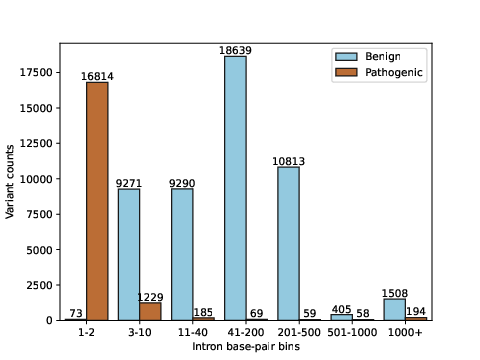

In [23]:
counts="out/out_clinvar_splicing/1s_l/intron_analysis/variant_counts/counts_per_intronic_bin_all.pdf"
img = WImage(filename=counts, resolution=75)
img

Performance drops significantly right after splice site positions, specially in donor-associated variants

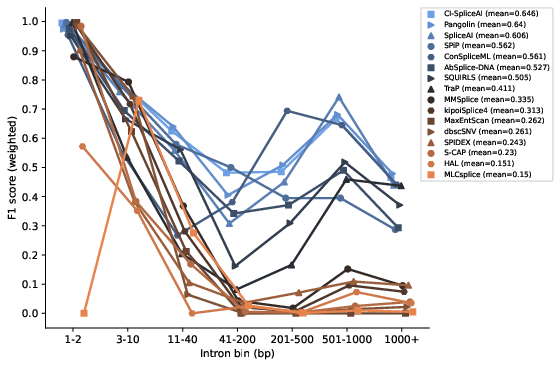

In [24]:
perf="out/out_clinvar_splicing/1s_l/intron_analysis/all_bin_together/per_bin_all_weighted_F1.pdf"
img = WImage(filename=perf, resolution=75)
img

How does the performance differs between variants closer to donors and acceptors ?

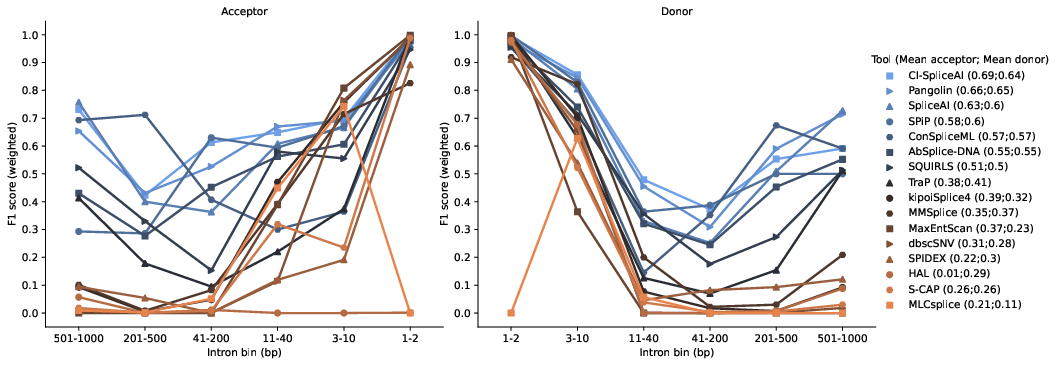

In [25]:
perf_per_bin="out/out_clinvar_splicing/1s_l/intron_analysis/all_bin_together/per_bin_all_split_ss_weighted_F1.pdf"
img = WImage(filename=perf_per_bin, resolution=75)
img

* ### Conservation scores

As for the Splicing tools, perfomance drops significantly after the two dinucleotides. However, there's a slight increase at deeper intronic space.

In [26]:
! rm data/clinvar/clinvar_to_VETA_evaluation.vcf.gz.tsv

cmd = "veta benchmark --out_dir out/out_clinvar_conservation \
    --scopes_to_evaluate Conservation \
    --types_of_variant snps \
    --metric weighted_F1 \
    --clinvar_stars 1s_l \
    --config data/clinvar/tools_config.txt \
    --skip_heatmap \
    --top_vep_consequence smallest_offset \
    --do_intronic_analysis \
    --split_splice_sites \
    data/clinvar/clinvar_to_VETA_evaluation.vcf.gz"

args = shlex.split(cmd)
with open('out/log_clinvar_conservation.txt', 'w') as f:
    subprocess.run(args,stderr=f, stdout=f, check=True)

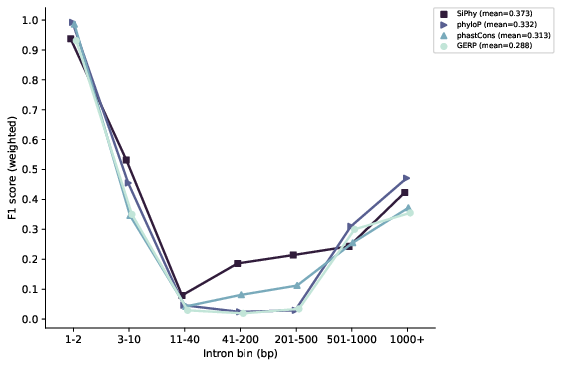

In [27]:
perf="out/out_clinvar_conservation/1s_l/intron_analysis/all_bin_together/per_bin_all_weighted_F1.pdf"
img = WImage(filename=perf, resolution=75)
img

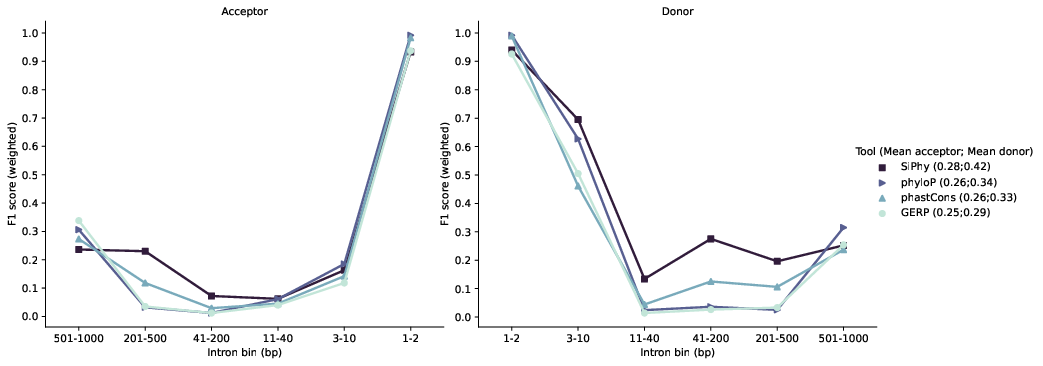

In [28]:
perf_per_bin="out/out_clinvar_conservation/1s_l/intron_analysis/all_bin_together/per_bin_all_split_ss_weighted_F1.pdf"
img = WImage(filename=perf_per_bin, resolution=75)
img

* ### Consequence agnostic predictors

In [29]:
! rm data/clinvar/clinvar_to_VETA_evaluation.vcf.gz.tsv
cmd = "veta benchmark --out_dir out/out_clinvar_whole_genome \
    --scopes_to_evaluate Whole_genome \
    --types_of_variant snps \
    --metric weighted_F1 \
    --clinvar_stars 1s_l \
    --config data/clinvar/tools_config.txt \
    --skip_heatmap \
    --top_vep_consequence smallest_offset \
    --do_intronic_analysis \
    --split_splice_sites \
    data/clinvar/clinvar_to_VETA_evaluation.vcf.gz" 

args = shlex.split(cmd)

with open('out/log_clinvar_whole_genome.txt', 'w') as f:
    subprocess.run(args,stderr=f, stdout=f, check=True)

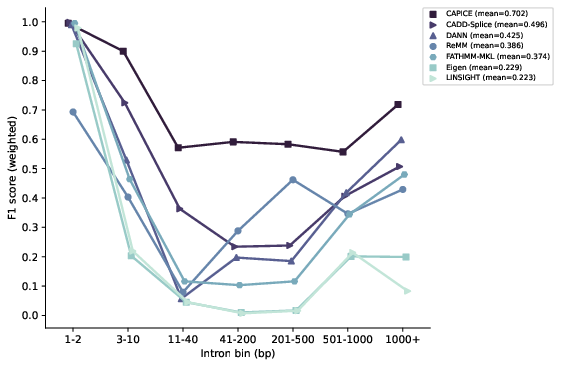

In [30]:
perf="out/out_clinvar_whole_genome/1s_l/intron_analysis/all_bin_together/per_bin_all_weighted_F1.pdf"
img = WImage(filename=perf, resolution=75)
img

CAPICE stood out with a weighted F1 score mean of > 0.7 across bins. Since training variants of this model is available, we wanted to control for type I circularity issues. Hence, we excluded variants from our evaluation dataset that were used in the training of either CAPICE. This lead to a exclusion of 14,491 variants from the clinvar intronic dataset. Thus, we performed again the evaluation of consequence-agnostic predictors using 54,117 variants.

In [31]:
! rm data/clinvar/1_circularity/clinvar_circularity_CAPICE.vcf.gz.tsv

cmd = "veta benchmark --out_dir out/out_clinvar_whole_genome_circularity \
    --scopes_to_evaluate Whole_genome \
    --types_of_variant snps \
    --metric weighted_F1 \
    --clinvar_stars 1s_l \
    --config data/clinvar/tools_config.txt \
    --skip_heatmap \
    --top_vep_consequence smallest_offset \
    --do_intronic_analysis \
    --split_splice_sites \
    data/clinvar/1_circularity/clinvar_circularity_CAPICE.vcf.gz"
    
args = shlex.split(cmd)

with open('out/log_clinvar_whole_genome_circularity.txt', 'w') as f:
    subprocess.run(args,stderr=f, stdout=f, check=True)

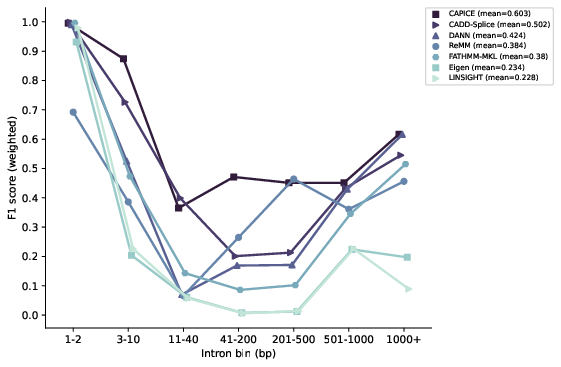

In [32]:
perf_per_bin="out/out_clinvar_whole_genome_circularity/1s_l/intron_analysis/all_bin_together/per_bin_all_weighted_F1.pdf"
img = WImage(filename=perf_per_bin, resolution=75)
img

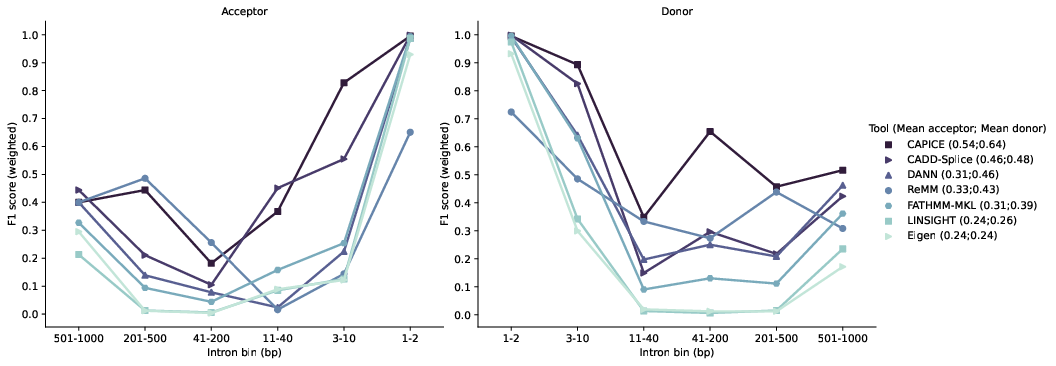

In [33]:
perf_per_bin="out/out_clinvar_whole_genome_circularity/1s_l/intron_analysis/all_bin_together/per_bin_all_split_ss_weighted_F1.pdf"
img = WImage(filename=perf_per_bin, resolution=75)
img

 * ### All tools together (to produce some plots with all tools)

All variants

In [34]:
! rm data/clinvar/clinvar_to_VETA_evaluation.vcf.gz.tsv

cmd = "veta benchmark --out_dir out/out_clinvar_all \
    --scopes_to_evaluate Splicing Conservation Whole_genome \
    --types_of_variant snps \
    --metric weighted_F1 \
    --clinvar_stars 1s_l \
    --config data/clinvar/tools_config_no_high_missing_splicing.txt \
    --skip_heatmap \
    --top_vep_consequence smallest_offset \
    --do_intronic_analysis \
    data/clinvar/clinvar_to_VETA_evaluation.vcf.gz"

args = shlex.split(cmd)

with open('out/log_clinvar_all.txt', 'w') as f:
    subprocess.run(args,stderr=f, stdout=f, check=True)

Excluding variants used in CAPICE training

In [35]:
! rm data/clinvar/1_circularity/clinvar_circularity_CAPICE.vcf.gz.tsv

cmd = "veta benchmark --out_dir out/out_clinvar_all_circ \
    --scopes_to_evaluate Splicing Conservation Whole_genome \
    --types_of_variant snps \
    --metric weighted_F1 \
    --clinvar_stars 1s_l \
    --config data/clinvar/tools_config_no_high_missing_splicing.txt \
    --skip_heatmap \
    --top_vep_consequence smallest_offset \
    --do_intronic_analysis \
    data/clinvar/1_circularity/clinvar_circularity_CAPICE.vcf.gz" 
    
args = shlex.split(cmd)

with open('out/log_clinvar_all_circ.txt', 'w') as f:
    subprocess.run(args,stderr=f, stdout=f, check=True)

 * ### Performance tends to increase slightly at the 501-1000 and 1000+bp bins. How is the performance on these variants which were split according to the category they belong ?

#### Exonic variants

In [36]:
cmd = "veta benchmark --out_dir out/out_clinvar_plus_500_exonic \
    --scopes_to_evaluate Splicing Conservation Whole_genome \
    --types_of_variant snps \
    --metric weighted_F1 \
    --clinvar_stars 1s_l \
    --config data/clinvar/tools_config.txt \
    --skip_heatmap \
    --top_vep_consequence smallest_offset \
    data/clinvar/2_plus_500/vcfs/exonic.vcf.gz" 

args = shlex.split(cmd)

with open('out/log_clinvar_plus_500_exonic.txt', 'w') as f:
    subprocess.run(args,stderr=f, stdout=f, check=True)

rm: data/clinvar/2_plus_500/vcfs/exonic.vcf.tsv: No such file or directory


#### Variants with only 1 consequence (hence, with the same transcript originally assigned)

In [37]:
cmd = "veta benchmark --out_dir out/out_clinvar_plus_500_intronic_1_conseq \
    --scopes_to_evaluate Splicing Conservation Whole_genome \
    --types_of_variant snps \
    --metric weighted_F1 \
    --clinvar_stars 1s_l \
    --config data/clinvar/tools_config.txt \
    --skip_heatmap \
    --top_vep_consequence smallest_offset \
    data/clinvar/2_plus_500/vcfs/1_conseq.vcf.gz" 
    
args = shlex.split(cmd)

with open('out/log_clinvar_plus_500_1_conseq.txt', 'w') as f:
    subprocess.run(args,stderr=f, stdout=f, check=True) 

rm: data/clinvar/2_plus_500/vcfs/1_conseq.vcf.tsv: No such file or directory


#### Variants with only more than 1 consequence, but all of them with the same offset as the original consequence

In [38]:
cmd = "veta benchmark --out_dir out/out_clinvar_plus_500_intronic_moreThan1Tx_same_offset \
    --scopes_to_evaluate Splicing Conservation Whole_genome \
    --types_of_variant snps \
    --metric weighted_F1 \
    --clinvar_stars 1s_l \
    --config data/clinvar/tools_config.txt \
    --skip_heatmap \
    --top_vep_consequence smallest_offset \
    data/clinvar/2_plus_500/vcfs/moreThan1Tx_same_offset.vcf.gz"
    
args = shlex.split(cmd)

with open('out/log_clinvar_plus_500_moreThan1Tx_same_offset.txt', 'w') as f:
    subprocess.run(args,stderr=f, stdout=f, check=True) 

rm: data/clinvar/2_plus_500/vcfs/moreThan1Tx_same_offset.vcf.tsv: No such file or directory


#### Variants with more than 1 consequence and having transcripts with a smaller variant offset

In [39]:
cmd = "veta benchmark --out_dir out/out_clinvar_plus_500_intronic_moreThan1Tx_smaller_offset \
    --scopes_to_evaluate Splicing Conservation Whole_genome \
    --types_of_variant snps \
    --metric weighted_F1 \
    --clinvar_stars 1s_l \
    --config data/clinvar/tools_config.txt \
    --skip_heatmap \
    --top_vep_consequence smallest_offset \
    data/clinvar/2_plus_500/vcfs/moreThan1Tx_smaller_offset.vcf.gz"
     
args = shlex.split(cmd)

with open('out/log_clinvar_plus_500_intronic_moreThan1Tx_smaller_offset.txt', 'w') as f:
    subprocess.run(args,stderr=f, stdout=f, check=True) 

rm: data/clinvar/2_plus_500/vcfs/moreThan1Tx_smaller_offset.vcf.tsv: No such file or directory


 * ### How is the overall performance at deep intronic bins (>500bp) after excluding variants that are exonic and closer-to splice sites in other transcripts ?

In [40]:
#config without splicing tools with high missing data
cmd = "veta benchmark --out_dir out/out_clinvar_excluding_exonic_and_closer_to_ss_all_tools \
    --scopes_to_evaluate Splicing \
    --types_of_variant snps \
    --metric weighted_F1 \
    --do_intronic_analysis \
    --clinvar_stars 1s_l \
    --config data/clinvar/3_excluding_exonic_and_closer_to_ss/tools_config.txt \
    --skip_heatmap \
    --top_vep_consequence smallest_offset \
    data/clinvar/3_excluding_exonic_and_closer_to_ss/clinvar_excluding_some_plus500bp.vcf.gz" 

args = shlex.split(cmd)

with open('out/log_clinvar_excluding_exonic_and_closer_to_ss_all_tools.txt', 'w') as f:
    subprocess.run(args,stderr=f, stdout=f, check=True) 

## **Manually curated dataset of pathogenic intronic variation** 

In [41]:
import os
import shlex
import subprocess
from wand.image import Image as WImage
os.makedirs("out", exist_ok=True)

#### *Analysis for Figure 2 and Supplementary Figure 3*

First, we will run a standard and faster benchmark without the `--do_intronic_analysis` flag. The goal is to see how all the tools behave overall, and test whether `Conservation` and `Whole_genome` (not splicing-specific) can be excluded from further analysis, since from now on all the variants evaluated are related with splicing aberrations.

Results show that most of these Conservation and Consequence-agnostic tools can be excluded (< 0.7), except for CADD-Splice. 

In [42]:
from wand.image import Image as WImage

Now, we run VETA for the selected tools and activate the `--do_threshold` and `--bootstrap` flag. We want to study how fit are the reference thresholds for deep intronic splicing-related variants. Clearly, some reference thresholds are not appropriate for distinguishing deep intronic pathogenic vs benign variants.

In [43]:
cmd ="veta benchmark --out_dir out/out_splicing_pathogenic_manual_curation \
    --types_of_variant all_types \
    --metric weighted_norm_mcc \
    --config data/splicing_pathogenic_manual_curation/tools_config.txt \
    --top_vep_consequence smallest_offset \
    --do_threshold_analysis \
    --bootstrapping \
    data/splicing_pathogenic_manual_curation/"

args = shlex.split(cmd)

with open('out/log_splicing_pathogenic_manual_curation.txt', 'w') as f:
    subprocess.run(args,stderr=f, stdout=f, check=True) 

Overall performance using the reference thresholds is modest, except for Pangolin and SpliceAI:

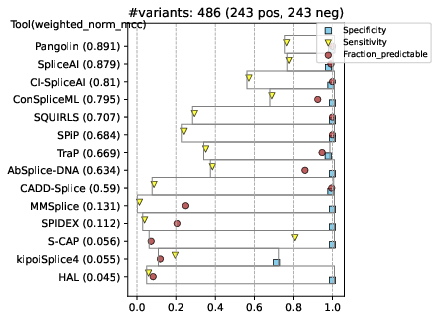

In [44]:
overall_perf="out/out_splicing_pathogenic_manual_curation/tools_benchmark/all_types/performance_at_fixed_thresh/scatter_all_types_all.pdf"
img = WImage(filename=overall_perf, resolution=75)
img

Overall performance using ROC curves reveals better results overall, with multiple tools with auROC > 0.9:

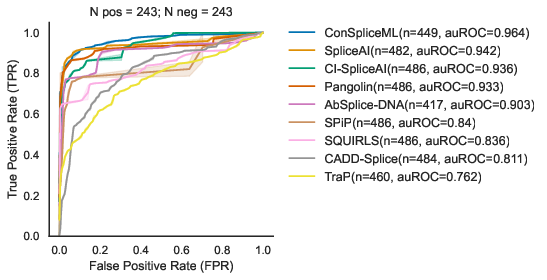

In [45]:
overall_perf="out/out_splicing_pathogenic_manual_curation/tools_benchmark/all_types/roc_analysis/ROC_all.pdf"
img = WImage(filename=overall_perf, resolution=75)
img

By running again a standard analysis using the new, adjusted thresholds, performance increases nicely.

In [46]:
! cp out/out_splicing_pathogenic_manual_curation/thresholds_analysis/new_configs/new_config_all_f0.5.txt data/splicing_pathogenic_manual_curation/
! cp out/out_splicing_pathogenic_manual_curation/thresholds_analysis/new_configs/new_config_all_f1.txt data/splicing_pathogenic_manual_curation/
! cp out/out_splicing_pathogenic_manual_curation/thresholds_analysis/new_configs/new_config_all_f1.5.txt data/splicing_pathogenic_manual_curation/

cmd = "veta benchmark --out_dir out/out_splicing_pathogenic_manual_curation_adj_thresholds \
    --types_of_variant all_types \
    --metric weighted_norm_mcc \
    --config data/splicing_pathogenic_manual_curation/new_config_all_f1.txt \
    --top_vep_consequence smallest_offset \
    data/splicing_pathogenic_manual_curation" 

args = shlex.split(cmd)

with open('out/log_splicing_pathogenic_manual_curation_adjusted_thresh.txt', 'w') as f:
    subprocess.run(args,stderr=f, stdout=f, check=True) 

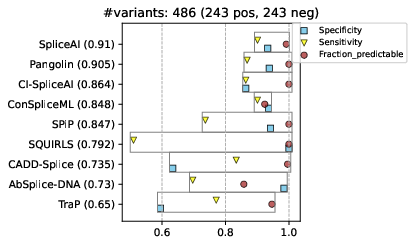

In [47]:
overall_perf="out/out_splicing_pathogenic_manual_curation_adj_thresholds/tools_benchmark/all_types/performance_at_fixed_thresh/scatter_all_types_all.pdf"
img = WImage(filename=overall_perf, resolution=75)
img

### **Pseudoexon activation vs Exon enlongation**

We run benchmarking for the two subsets of variants separately, and then evaluate them using the R script `2_manual_curated_dataset_Elong_vs_PseudoExon.R` under the scripts directory.

In [48]:
cmd = "veta benchmark --out_dir out/out_splicing_pathogenic_manual_curation_pe_only \
    --types_of_variant all_types \
    --metric weighted_norm_mcc \
    --top_vep_consequence smallest_offset \
    --config data/splicing_pathogenic_manual_curation/new_config_all_f1.txt \
    data/splicing_pathogenic_manual_curation/pseudoexon_activation/"
 
args = shlex.split(cmd)

with open('out/log_out_splicing_pathogenic_manual_curation_pe_only.txt', 'w') as f:
    subprocess.run(args,stderr=f, stdout=f, check=True)   

In [49]:
cmd = "veta benchmark --out_dir out/out_splicing_pathogenic_manual_curation_pir_only \
    --types_of_variant all_types \
    --metric weighted_norm_mcc \
    --top_vep_consequence smallest_offset \
    --config data/splicing_pathogenic_manual_curation/new_config_all_f1.txt  \
    data/splicing_pathogenic_manual_curation/partial_intron_retention/" 
    
args = shlex.split(cmd)

with open('out/log_out_splicing_pathogenic_manual_curation_pir_only.txt', 'w') as f:
    subprocess.run(args,stderr=f, stdout=f, check=True)

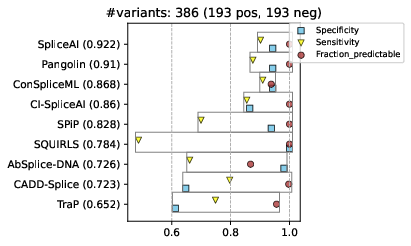

In [50]:
! cp out/out_splicing_pathogenic_manual_curation_pe_only/tools_benchmark/all_types/results_tsv/statistics_all_types_all.tsv data/splicing_pathogenic_manual_curation/pseudoexon_activation
overall_perf="out/out_splicing_pathogenic_manual_curation_pe_only/tools_benchmark/all_types/performance_at_fixed_thresh/scatter_all_types_all.pdf"
img = WImage(filename=overall_perf, resolution=75)
img

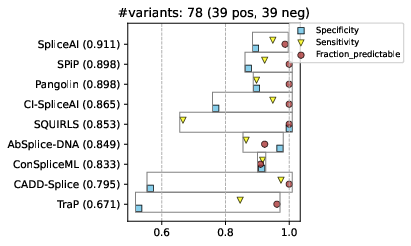

In [51]:
! cp out/out_splicing_pathogenic_manual_curation_pir_only/tools_benchmark/all_types/results_tsv/statistics_all_types_all.tsv data/splicing_pathogenic_manual_curation/partial_intron_retention
overall_perf="out/out_splicing_pathogenic_manual_curation_pir_only/tools_benchmark/all_types/performance_at_fixed_thresh/scatter_all_types_all.pdf"
img = WImage(filename=overall_perf, resolution=75)
img

# **Variants affecting RNA splicing**

#### *Analysis for Figure 3, Supplementary Figure 4, Supplementary Figure 5 and Supplementary Figure 6*

This section of the analysis focuses on the comparison of prediction tools to identify splicing-altering variants that do so by different mechanisms. Some alter the branchpoint signal in the intron upstream, others create a new splice site that trigger pseudoexon inclusion, others activate existing cryptic splice sites that lead to exon elongation/partial intron retention. Several datasets were integrated and curated for this study:

* [VazDrago 2017](https://pubmed.ncbi.nlm.nih.gov/28497172/) and PedroBarbosa 2022 (N splicing altering=243): Our own curated list of disease-causing variants by means of alteration of RNA splicing. Used in the previous section, but here they are decomposed in different categories. 
* [Keegan 2022](https://pubmed.ncbi.nlm.nih.gov/35140743/) (N splicing altering=153): Comprehensive curation of variants that drive cryptic splicing, not all of them causing disease. Some overlap with our own curation, but many variants are unique. Large indels and coding variants were discarded. 
* [Petersen 2021](https://onlinelibrary.wiley.com/doi/full/10.1002/humu.24306) (N splicing altering=12): Comprehensive analysis of pseudoexon activation caused by intronic variants that do not create splice sites. Most of them create/repress/alter splicing regulatory elements within the generated pseudoexon. Many variants are already present in the two previous curation, hence the reduced final number of unique variants used.
* [Tubeuf 2020](https://onlinelibrary.wiley.com/doi/full/10.1002/humu.24091) (N splicing altering=3): Benchmark of user-friendly tools with variants that induce alterations in splicing regulatory elements. Most of variants collected are exonic, therefore we removed them. For a small set of intronic variants that induce pseudoexon activation (N=13), we selected 3 that are not present in any of the previous datasets collected.
* [Jung 2021](https://pubmed.ncbi.nlm.nih.gov/33420369/) (N splicing altering=252): Comprehensive caracterization of intronic mis-splicing in human cancers. They developed a method to caracterize intronic variation and its effect of splicing based on RNA-seq data. 
* [Moles-Fernández 2021](https://pubmed.ncbi.nlm.nih.gov/34283047/) (N splicing altering=19; N splicing neutral=99): Evaluation of the impact of splicing regulatory elements in the identification of variants in hereditary breast/ovarian cancer genes. Datasets collected from manual literature search as well as from other studies.
* [Adamson 2018](https://pubmed.ncbi.nlm.nih.gov/29859120/) (N splicing neutral=283): A MPRA (Vex-seq) to test the impact of 2059 variants in RNA-splicing spanning 110 alternative exons. Variants with no splicing effect (dPSI < 1) were selected, yielding a balanced number of exonic (to be compared with the splicing-altering variants ocurring within activated pseudoexons) and intronic variants.
* [Cheung 2019](https://pubmed.ncbi.nlm.nih.gov/30503770/) (N splicing neutral=109): Multiplexed functional assay (MFASS) that assayed the splicing effect of 27,733 variants from ExAC. Variants with no splicing effect (dPSI < 2 in both replicates) were selected. 
  
Here, we evaluate the performance of different methods on two broad classes (pseudoexon activation vs exon elongation), and then within each class we look at different splicing mechanisms. Because the number of branchpoint-related variants was small, we analyzed them into one separate class. Then, within each class we look at variants that activate donors, acceptors or affect splicing regulatory elements. 

To group variants from different studies into each splicing category, we run the R script `scripts/2_per_study_to_category.R` to generate the variant positions corresponding to each category. Then, the following commands were run to generate category-specific VCF files (which are commented, because the final files are already in the repo, and the commands would not work as some auxiliary files were removed):

In [52]:
# #Branchpoint
#! zcat < data/splicing_altering/per_category/all_concat_deleterious.vcf.gz | grep -e "^#" -e "CHROM" -wf data/splicing_altering/per_category/branchpoint_associated/position_positive.txt | cut -f1-8 | bgzip > data/splicing_altering/per_category/branchpoint_associated/deleterious.vcf.gz
#! zcat < data/splicing_altering/per_category/all_concat_neutral.vcf.gz | grep -e "^#" -e "CHROM" -wf data/splicing_altering/per_category/branchpoint_associated/position_negative.txt | cut -f1-8 | bgzip > data/splicing_altering/per_category/branchpoint_associated/neutral.vcf.gz

# # PE SRE
#! zcat < data/splicing_altering/per_category/all_concat_deleterious.vcf.gz | grep -e "^#" -e "CHROM" -wf data/splicing_altering/per_category/pe_activation/sre_associated/position_positive.txt | cut -f1-8 | bgzip > data/splicing_altering/per_category/pe_activation/sre_associated/deleterious.vcf.gz
#! zcat < data/splicing_altering/per_category/all_concat_neutral.vcf.gz | grep -e "^#" -e "CHROM" -wf data/splicing_altering/per_category/pe_activation/sre_associated/position_negative.txt | cut -f1-8 | bgzip > data/splicing_altering/per_category/pe_activation/sre_associated/neutral.vcf.gz

# # PE DONOR
#! zcat < data/splicing_altering/per_category/all_concat_deleterious.vcf.gz | grep -e "^#" -e "CHROM" -wf data/splicing_altering/per_category/pe_activation/new_donor/position_positive.txt | cut -f1-8 | bgzip > data/splicing_altering/per_category/pe_activation/new_donor/deleterious.vcf.gz
#! zcat < data/splicing_altering/per_category/all_concat_neutral.vcf.gz | grep -e "^#" -e "CHROM" -wf data/splicing_altering/per_category/pe_activation/new_donor/position_negative.txt | cut -f1-8 | bgzip > data/splicing_altering/per_category/pe_activation/new_donor/neutral.vcf.gz

# # PE DONOR ASSOCIATED
#! zcat < data/splicing_altering/per_category/all_concat_deleterious.vcf.gz | grep -e "^#" -e "CHROM" -wf data/splicing_altering/per_category/pe_activation/donor_downstream/position_positive.txt | cut -f1-8 | bgzip > data/splicing_altering/per_category/pe_activation/donor_downstream/deleterious.vcf.gz
#! zcat < data/splicing_altering/per_category/all_concat_neutral.vcf.gz | grep -e "^#" -e "CHROM" -wf data/splicing_altering/per_category/pe_activation/donor_downstream/position_negative.txt | cut -f1-8 | bgzip > data/splicing_altering/per_category/pe_activation/donor_downstream/neutral.vcf.gz

# # PE ACCEPTOR ASSOCIATED
#! zcat < data/splicing_altering/per_category/all_concat_deleterious.vcf.gz | grep -e "^#" -e "CHROM" -wf data/splicing_altering/per_category/pe_activation/acceptor_associated/position_positive.txt | cut -f1-8 | bgzip > data/splicing_altering/per_category/pe_activation/acceptor_associated/deleterious.vcf.gz
#! zcat < data/splicing_altering/per_category/all_concat_neutral.vcf.gz | grep -e "^#" -e "CHROM" -wf data/splicing_altering/per_category/pe_activation/acceptor_associated/position_negative.txt | cut -f1-8 | bgzip > data/splicing_altering/per_category/pe_activation/acceptor_associated/neutral.vcf.gz

# # ELONG SRE
#! zcat < data/splicing_altering/per_category/all_concat_deleterious.vcf.gz | grep -e "^#" -e "CHROM" -wf data/splicing_altering/per_category/exon_elongation/sre_associated/position_positive.txt | cut -f1-8 | bgzip > data/splicing_altering/per_category/exon_elongation/sre_associated/deleterious.vcf.gz
#! zcat < data/splicing_altering/per_category/all_concat_neutral.vcf.gz | grep -e "^#" -e "CHROM" -wf data/splicing_altering/per_category/exon_elongation/sre_associated/position_negative.txt | cut -f1-8 | bgzip > data/splicing_altering/per_category/exon_elongation/sre_associated/neutral.vcf.gz

# # ELONG DONOR
#! zcat < data/splicing_altering/per_category/all_concat_deleterious.vcf.gz | grep -e "^#" -e "CHROM" -wf data/splicing_altering/per_category/exon_elongation/new_donor/position_positive.txt | cut -f1-8 | bgzip > data/splicing_altering/per_category/exon_elongation/new_donor/deleterious.vcf.gz
#! zcat < data/splicing_altering/per_category/all_concat_neutral.vcf.gz | grep -e "^#" -e "CHROM" -wf data/splicing_altering/per_category/exon_elongation/new_donor/position_negative.txt | cut -f1-8 | bgzip > data/splicing_altering/per_category/exon_elongation/new_donor/neutral.vcf.gz

# # ELONG DONOR ASSOCIATED
#! zcat < data/splicing_altering/per_category/all_concat_deleterious.vcf.gz | grep -e "^#" -e "CHROM" -wf data/splicing_altering/per_category/exon_elongation/donor_downstream/position_positive.txt | cut -f1-8 | bgzip > data/splicing_altering/per_category/exon_elongation/donor_downstream/deleterious.vcf.gz
#! zcat < data/splicing_altering/per_category/all_concat_neutral.vcf.gz | grep -e "^#" -e "CHROM" -wf data/splicing_altering/per_category/exon_elongation/donor_downstream/position_negative.txt | cut -f1-8 | bgzip > data/splicing_altering/per_category/exon_elongation/donor_downstream/neutral.vcf.gz

# # ELONG ACCEPTOR ASSOCIATED
#! zcat < data/splicing_altering/per_category/all_concat_deleterious.vcf.gz | grep -e "^#" -e "CHROM" -wf data/splicing_altering/per_category/exon_elongation/acceptor_associated/position_positive.txt | cut -f1-8 | bgzip > data/splicing_altering/per_category/exon_elongation/acceptor_associated/deleterious.vcf.gz
#! zcat < data/splicing_altering/per_category/all_concat_neutral.vcf.gz | grep -e "^#" -e "CHROM" -wf data/splicing_altering/per_category/exon_elongation/acceptor_associated/position_negative.txt | cut -f1-8 | bgzip > data/splicing_altering/per_category/exon_elongation/acceptor_associated/neutral.vcf.gz

In [53]:
from wand.image import Image as WImage
import os
import shlex
import subprocess
from wand.image import Image as WImage
os.makedirs("out", exist_ok=True)

## **1) Branchpoint-associated variants**

This dataset is composed by 62 intronic variants that affect the branchpoint signal (located -18 to -44bp upstream of an annotated splicing acceptor), usually leading to intron retention and/or exon skipping. There are few exceptions that actually do the opposite, by creating a new branchpoint and leading to partial intron retention and/or pseudoexon activations. Variants from Jung (N=48), PedroBarbosa (N=9), Petersen (N=1), Moles-Fernandez (N=1) and Keegan (N=3) are included here. The neutral dataset (N=95) is composed of experimentally validated variants that between the -18 and -44 bp upstream of existing splicing acceptors, and did not lead to any splicing change. Variants from Adamson_Vex_seq (N=59), Moles-Fernández (N=2) and Cheung_MFASS (N=34) compose this neutral set.

For this analyis, we additionally incorporate branchpoint-specific tools such as BPP, labranchoR, SVM BP finder and BPHunter. Additionally, we tested IntSplice2 and regSNP-intron that are targeted to make predictions in these regions. The steps to generate VCFs with the variant effect scores for these tools (except for labRanchoR that was run using kipoi, and VETA has internal functions to automatically process its ouput) can be inspected [here](https://github.com/PedroBarbosa/Prepare_SplicingPredictors).

In [54]:
cmd = "veta benchmark --out_dir out/out_branchpoint \
    --types_of_variant all_types \
    --metric weighted_norm_mcc \
    --config data/splicing_altering/per_category/branchpoint_associated/tools_config.txt \
    --do_machine_learning \
    data/splicing_altering/per_category/branchpoint_associated/" 

args = shlex.split(cmd)

with open('out/log_branchpoint.txt', 'w') as f:
    subprocess.run(args,stderr=f, stdout=f, check=True)

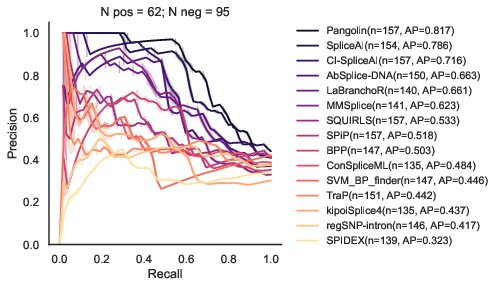

In [78]:
! cp out/out_branchpoint/tools_benchmark/all_types/results_tsv/statistics_all_types_all.tsv data/splicing_altering/per_category/branchpoint_associated/
! cp out/out_branchpoint/tools_benchmark/all_types/results_tsv/preds_all_types_all_class.tsv data/splicing_altering/per_category/branchpoint_associated/
perf="out/out_branchpoint/tools_benchmark/all_types/roc_analysis/ROC_pr_all.pdf"
img = WImage(filename=perf, resolution=75)
img

In [56]:
#! mkdir data/splicing_altering/per_category/branchpoint_associated/data_wrong_spliceAI_pangolin
#! python scripts/5_check_unique_predictions.py --preds_file data/splicing_altering/per_category/branchpoint_associated/preds_all_types_all_class.tsv --just_deleterious --exclude_tools SpliceAI Pangolin > data/splicing_altering/per_category/branchpoint_associated/data_wrong_spliceAI_pangolin/pos.txt
# ! zcat < data/splicing_altering/per_category/branchpoint_associated/deleterious.vcf.gz | grep -wf data/splicing_altering/per_category/branchpoint_associated/data_wrong_spliceAI_pangolin/pos.txt -e "^#" -e "^#CHROM" | bgzip > data/splicing_altering/per_category/branchpoint_associated/data_wrong_spliceAI_pangolin/deleterious.vcf.gz
# ! zcat < data/splicing_altering/per_category/branchpoint_associated/neutral.vcf.gz | grep -wf data/splicing_altering/per_category/branchpoint_associated/data_wrong_spliceAI_pangolin/pos.txt -e "^#" -e "^#CHROM"| bgzip > data/splicing_altering/per_category/branchpoint_associated/data_wrong_spliceAI_pangolin/neutral.vcf.gz

cmd = "veta benchmark --out_dir out/out_branchpoint_wrongSpliceAI_pangolin \
    --types_of_variant all_types \
    --metric weighted_F1 \
    --config data/splicing_altering/per_category/branchpoint_associated/tools_config.txt \
    data/splicing_altering/per_category/branchpoint_associated/data_wrong_spliceAI_pangolin" 

args = shlex.split(cmd)

with open('out/log_branchpoint_wrongSpliceAI_pangolin.txt', 'w') as f:
    subprocess.run(args,stderr=f, stdout=f, check=True)

## **2) Variants that trigger pseudoexon inclusion**

This dataset is composed by deep intronic variants that activate the expression of pseudoexons. We analyze four different subsets that activate this sequences by different mechanisms.

### **A) Variants that are associated with splicing acceptors**

Dataset composed by 89 deep intronic variants that trigger pseudoexon inclusion by the creation of a new splicing acceptor, or by strenghthening a cryptic one, usually affecting a cryptic polypirimidine tract (positive set). Variants from VazDrago (N=13), PedroBarbosa (N=28), Keegan (N=32), Jung (N=13) and Moles-Fernández (N=2) and petersen (N=1) are included here. The neutral dataset was not straightforward to generate, since it is hard to gather experimentally validated variants that "create" new splice acceptors and do not lead to any splicing switch. Therefore, to mimic as close as possible the positive set, we looked for common deep intronic SNVs (> 5\% AF) protein-coding variants in gnomAD that generate the most common 5-mer acceptor C**AG**GT in the human genome ([Sibley et al., 2016](https://www.nature.com/articles/nrg.2016.46)). From the obtained set, we randomly selected 67 variants (same as the positive set that create a new splice acceptor) to serve the control set. We also gathered variants upstream of splicing acceptors to match with the set of positive variants that strengthen existing cryptic splice acceptors. Hence, merging all these sets we generated 110 control variants: Moles-Fernández (N=30), Adamson_Vex-seq (N=13) and gnomAD v2.1 (N=67).

For this analyis, we additionally incorporate some deep learning methods that predict splice sites, since they should be able to capture variant effects the same way SpliceAI and others do. They are SpliceRover, Spliceator and DSSP. The steps to generate VCFs with the variant effect scores for these tools can be inspected [here](https://github.com/PedroBarbosa/Prepare_SplicingPredictors).

In [57]:
cmd = "veta benchmark --out_dir out/out_pe_acceptor_associated \
    --types_of_variant all_types \
    --metric weighted_norm_mcc \
    --config data/splicing_altering/per_category/pseudoexon_activation/acceptor_associated/tools_config.txt \
    data/splicing_altering/per_category/pseudoexon_activation/acceptor_associated" 

args = shlex.split(cmd)

with open('out/log_pe_acceptor_associated.txt', 'w') as f:
    subprocess.run(args,stderr=f, stdout=f, check=True)

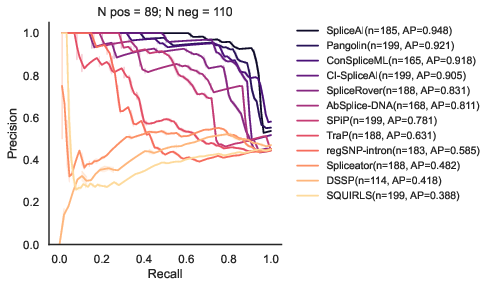

In [58]:
! cp out/out_pe_acceptor_associated/tools_benchmark/all_types/results_tsv/statistics_all_types_all.tsv data/splicing_altering/per_category/pseudoexon_activation/acceptor_associated
perf="out/out_pe_acceptor_associated/tools_benchmark/all_types/roc_analysis/ROC_pr_all.pdf"
img = WImage(filename=perf, resolution=75)
img

### **B) Variants that affect splicing regulatory elements (Exonic-like category)**

This dataset is composed by 76 intronic variants that affect SREs and usually lead to the inclusion of pseudoexons (positive set). Variants from all sources were included here (VazDrago (N=8), PedroBarbosa (N=16), Petersen (N=9), Tubeuf (N=3), Moles_Fernandez (N=1), Keegan (N=15), Jung (N=24)). The neutral dataset (variants that do not change splicing, negative set) refers to a set of exonic variants (to resemble as much as possible the positive set) that were proven to not affect splicing. This set comes exclusively from Adamson_Vex_seq (N=123) and 90 variants were randomly selected to balance with the positive set.

For this analysis, we additionally incorporate user-friendly tools such as HEXplorer and ESRseq scores originated from the QUEPASA method. The steps to generate VCFs with the variant effect scores of each of these method can be inspected [here](https://github.com/PedroBarbosa/Prepare_SplicingPredictors).

In [59]:
cmd = "veta benchmark --out_dir out/out_pe_exonic_like \
    --types_of_variant all_types \
    --metric weighted_norm_mcc \
    --config data/splicing_altering/per_category/pseudoexon_activation/exonic_like/tools_config.txt \
    data/splicing_altering/per_category/pseudoexon_activation/exonic_like" 
    
args = shlex.split(cmd)

with open('out/log_pe_exonic_like.txt', 'w') as f:
    subprocess.run(args,stderr=f, stdout=f, check=True)

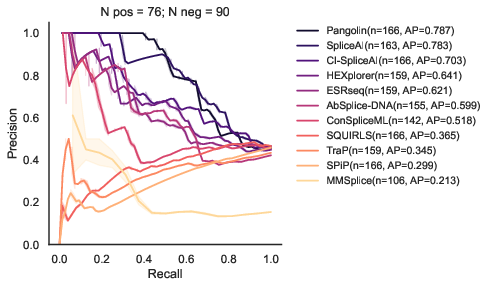

In [60]:
! cp out/out_pe_exonic_like/tools_benchmark/all_types/results_tsv/statistics_all_types_all.tsv data/splicing_altering/per_category/pseudoexon_activation/exonic_like
! cp out/out_pe_exonic_like/tools_benchmark/all_types/results_tsv/preds_all_types_all_class.tsv data/splicing_altering/per_category/pseudoexon_activation/exonic_like
perf="out/out_pe_exonic_like/tools_benchmark/all_types/roc_analysis/ROC_pr_all.pdf"
img = WImage(filename=perf, resolution=75)
img

Let's check the variant positions that were not captured by SpliceAI using pre-computed scores, so that we can manually test these variants using SpliceAI lookup database (with larger max distance size)

In [61]:
# ! python scripts/5_check_unique_predictions.py --preds_file data/splicing_altering/per_category/pseudoexon_activation/exonic_like/preds_all_types_all_class.tsv --just_deleterious --exclude_tools SpliceAI 

### **C) Variants that create a new splicing donor**

Dataset composed by 171 deep intronic variants that trigger pseudoexon inclusion by the creation of a new splicing donor (positive set). Variants from VazDrago (N=40), PedroBarbosa (N=35), Keegan (N=73), Jung (N=16) and Moles-Fernández (N=7) are included here. A control dataset (N=211) was generated as for the new splice acceptor variants. To mimic as close as possible the positive set, we looked for common deep intronic SNVs (> 5\% AF) protein-coding variants in gnomAD that generate the most common 6-mer donor G**GT**AAG in the human genome ([Sibley et al., 2016](https://www.nature.com/articles/nrg.2016.46)). From the obtained set, we randomly selected 171 variants to serve as negative set, whereas the remaining one (N=40) will serve as controls for an upcoming section (new donor variants that trigger partial intron retention).

For this analyis, we additionally incorporate some deep learning methods that predict splice sites, since they should be able to capture variant effects the same way SpliceAI and others do. They are SpliceRover, Spliceator and DSSP. The steps to generate VCFs with the variant effect scores for these tools can be inspected [here](https://github.com/PedroBarbosa/Prepare_SplicingPredictors).

In [62]:
cmd = " veta benchmark --out_dir out/out_pe_new_donor \
    --types_of_variant all_types \
    --metric weighted_norm_mcc \
    --config data/splicing_altering/per_category/pseudoexon_activation/new_donor/tools_config.txt \
    data/splicing_altering/per_category/pseudoexon_activation/new_donor/" 
    
args = shlex.split(cmd)

with open('out/log_pe_new_donor.txt', 'w') as f:
    subprocess.run(args,stderr=f, stdout=f, check=True)

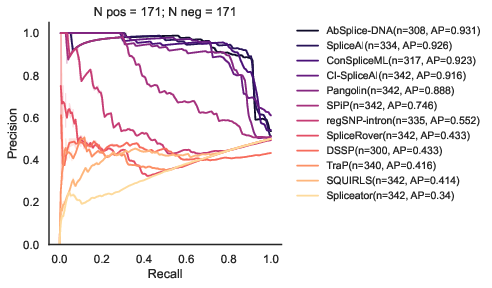

In [63]:
! cp out/out_pe_new_donor/tools_benchmark/all_types/results_tsv/statistics_all_types_all.tsv data/splicing_altering/per_category/pseudoexon_activation/new_donor
perf="out/out_pe_new_donor/tools_benchmark/all_types/roc_analysis/ROC_pr_all.pdf"
img = WImage(filename=perf, resolution=75)
img

### **D) Variants that enhance cryptic splice donors (ocurring downstream of them)**

Dataset composed by 93 deep intronic variants that trigger pseudoexon inclusion by activation of a near-by upstream splicing donor (positive set). Variants from VazDrago (N=13), PedroBarbosa (N=26), Keegan (N=30), Jung (N=22) and Moles-Fernández (N=1) and Petersen (N=1) are included here. A control dataset (N=99) was generated by selecting donor-associated at >20bp from the upstream donor. Variants from Adamson (N=19), Cheung (N=19) and Moles-Fernandez (N=61) are presented here.

For this analyis, we additionally incorporate some additionally deep learning methods that predict splice sites, since they should be able to capture variant effects the same way SpliceAI and others do. They are SpliceRover, Spliceator. The steps to generate VCFs with the variant effect scores for these tools can be inspected [here](https://github.com/PedroBarbosa/Prepare_SplicingPredictors).

In [64]:
cmd = "veta benchmark --out_dir out/out_pe_donor_downstream \
    --types_of_variant all_types \
    --metric weighted_norm_mcc \
    --config data/splicing_altering/per_category/pseudoexon_activation/donor_downstream/tools_config.txt \
    data/splicing_altering/per_category/pseudoexon_activation/donor_downstream/" 

args = shlex.split(cmd)

with open('out/log_pe_donor_downstream.txt', 'w') as f:
    subprocess.run(args,stderr=f, stdout=f, check=True)

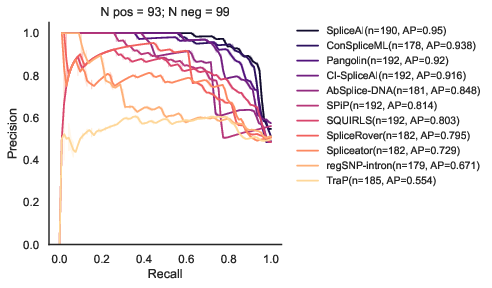

In [65]:
! cp out/out_pe_donor_downstream/tools_benchmark/all_types/results_tsv/statistics_all_types_all.tsv data/splicing_altering/per_category/pseudoexon_activation/donor_downstream
perf="out/out_pe_donor_downstream/tools_benchmark/all_types/roc_analysis/ROC_pr_all.pdf"
img = WImage(filename=perf, resolution=75)
img

## **2) Variants leading to partial intron retention (exon elongation)**

This dataset is composed by intronic variants that partial intron retention. We analyze four different subsets that lead to this functional outcome.

### **A) Variants that are associated with splicing acceptors**

Dataset composed by 44 intronic variants that trigger exon elongation by the creation of a new splicing acceptor, or by strenghthening a cryptic one, usually affecting a cryptic polypirimidine tract (positive set). Variants from VazDrago (N=2), PedroBarbosa (N=10), Jung (N=31) and Moles-Fernández (N=1) are included here. The control dataset (N=61) was generated based on the proximity of variants to annotated exons located between -3 and -18 and -44 and 150bp upstream of the splice acceptors. Variants from Adamson_Vex_seq (N=38), Cheung_MFASS (N=17) and Moles-Fernandez (N=6) were used.

Just like before (for pseudoexon-activating variants), we incorporate some deep learning methods that predict splice sites, since they should be able to capture variant effects the same way SpliceAI and others do. They are SpliceRover, Spliceator and DSSP. The steps to generate VCFs with the variant effect scores for these tools can be inspected [here](https://github.com/PedroBarbosa/Prepare_SplicingPredictors).

In [66]:
cmd = "veta benchmark --out_dir out/out_partial_ir_acceptor_associated \
    --types_of_variant all_types \
    --metric weighted_norm_mcc \
    --config data/splicing_altering/per_category/partial_intron_retention/acceptor_associated/tools_config.txt \
    data/splicing_altering/per_category/partial_intron_retention/acceptor_associated" 

args = shlex.split(cmd)

with open('out/log_partial_ir_acceptor_associated.txt', 'w') as f:
    subprocess.run(args,stderr=f, stdout=f, check=True)

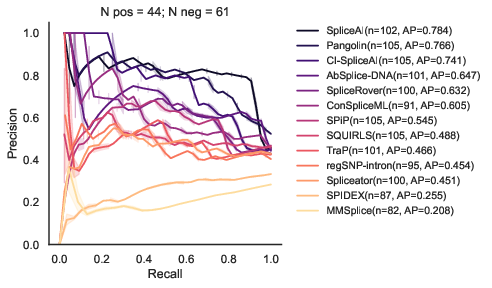

In [67]:
! cp out/out_partial_ir_acceptor_associated/tools_benchmark/all_types/results_tsv/statistics_all_types_all.tsv data/splicing_altering/per_category/partial_intron_retention/acceptor_associated/
perf="out/out_partial_ir_acceptor_associated/tools_benchmark/all_types/roc_analysis/ROC_pr_all.pdf"
img = WImage(filename=perf, resolution=75)
img

### **B) Variants that affect splicing regulatory elements (Exonic-like category)**

This subset contains intronic variants that trigger partial intron retention, being consired exonic in the new aberrant product. It is composed by 30 that probably affect SREs and enhance the usage of either a downstream donor or upstream acceptor (positive set). Most of these variants were detected in Jung (N=27), with few coming from other studies too: Moles-Fernandez (N=1), pbarbosa (N=1) and vazDrago (N=1). The control dataset (variants that do not change splicing, negative set) refers to a set of exonic variants (to resemble as much as possible the positive set) that were tested to not affect splicing. This set comes exclusively from Adamson_Vex_seq (N=123) and 33 variants were randomly selected to balance with the positive set.

For this analysis, we additionally incorporate user-friendly tools such as HEXplorer and ESRseq scores originated from the QUEPASA method. The steps to generate VCFs with the variant effect scores of each of these method can be inspected [here](https://github.com/PedroBarbosa/Prepare_SplicingPredictors).

In [68]:
cmd = "veta benchmark --out_dir out/out_partial_ir_exonic_like \
    --types_of_variant all_types \
    --metric weighted_norm_mcc \
    --config data/splicing_altering/per_category/partial_intron_retention/exonic_like/tools_config.txt \
    data/splicing_altering/per_category/partial_intron_retention/exonic_like" 
    
args = shlex.split(cmd)

with open('out/log_partial_ir_exonic_like.txt', 'w') as f:
    subprocess.run(args,stderr=f, stdout=f, check=True)

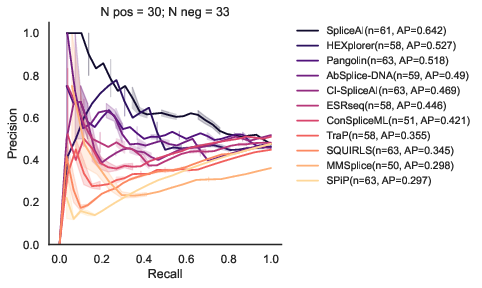

In [69]:
! cp out/out_partial_ir_exonic_like/tools_benchmark/all_types/results_tsv/statistics_all_types_all.tsv data/splicing_altering/per_category/partial_intron_retention/exonic_like/
! cp out/out_partial_ir_exonic_like/tools_benchmark/all_types/results_tsv/preds_all_types_all_class.tsv data/splicing_altering/per_category/partial_intron_retention/exonic_like/
perf="out/out_partial_ir_exonic_like/tools_benchmark/all_types/roc_analysis/ROC_pr_all.pdf"
img = WImage(filename=perf, resolution=75)
img

Just like before, as done with pseudoexon-activating variants, we checked the variant positions that were not captured by SpliceAI using pre-computed scores to then run again SpliceAI using SpliceAI lookup

In [70]:
# ! python scripts/5_check_unique_predictions.py --preds_file data/splicing_altering/per_category/partial_intron_retention/exonic_like/preds_all_types_all_class.tsv --just_deleterious --exclude_tools SpliceAI 

### **C) Variants that create a new splicing donor**

Dataset composed by 39 intronic variants that create a new splice donor and lead to exon elongation/partial intron retention (positive set). Variants from VazDrago (N=2), PedroBarbosa (N=10), Jung (N=25) and Moles-Fernández (N=2) are included here. A control dataset (N=40) was generated by randomly selecting 40 variants from the set of 211 gnomAD variants that create a new splice donor motif.

As before, we also incorporate deep learning methods that predict splice sites. They are SpliceRover, Spliceator and DSSP. The steps to generate VCFs with the variant effect scores for these tools can be inspected [here](https://github.com/PedroBarbosa/Prepare_SplicingPredictors).

In [71]:
cmd = "veta benchmark --out_dir out/out_partial_ir_new_donor \
    --types_of_variant all_types \
    --metric weighted_norm_mcc \
    --config data/splicing_altering/per_category/partial_intron_retention/new_donor/tools_config.txt \
    data/splicing_altering/per_category/partial_intron_retention/new_donor/" 

args = shlex.split(cmd)

with open('out/log_partial_ir_new_donor.txt', 'w') as f:
    subprocess.run(args,stderr=f, stdout=f, check=True)    

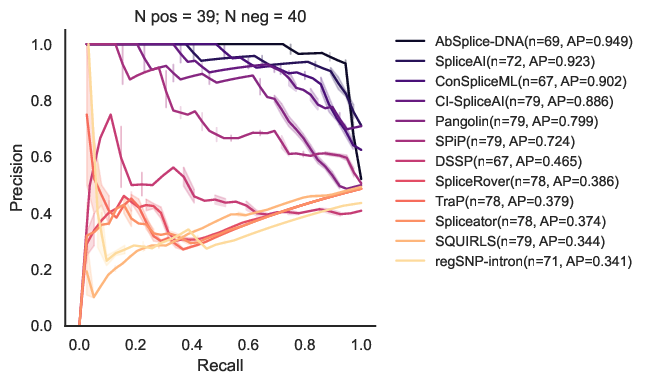

In [77]:
! cp out/out_partial_ir_new_donor/tools_benchmark/all_types/results_tsv/statistics_all_types_all.tsv data/splicing_altering/per_category/partial_intron_retention/new_donor/
perf="out/out_partial_ir_new_donor/tools_benchmark/all_types/roc_analysis/ROC_pr_all.pdf"
img = WImage(filename=perf, resolution=100)
img

### **D) Variants that enhance cryptic splice donors (ocurring downstream of them)**

Dataset composed by 55 intronic variants that trigger partial intron retention by enhancing the usage of an upstream cryptic splicing donor (positive set). Variants from Jung (N=46), PedroBarbosa (N=6), VazDrago (N=2), and Moles-Fernández (N=1) are included here. A neutral dataset (N=70) was generated by looking at intronic variants located at <20bp from the upstream splice donor that were experimentally tested to have no effect on splicing of the upstream exon. Variants from Adamson_Vex_seq (N=31) and Cheung_MFASS (N=39) are included here.

For this analyis, we also included SpliceRover and Spliceator. The steps to generate VCFs with the variant effect scores for these tools can be inspected [here](https://github.com/PedroBarbosa/Prepare_SplicingPredictors).

In [73]:
cmd = "veta benchmark --out_dir out/out_partial_ir_donor_downstream \
    --types_of_variant all_types \
    --metric weighted_norm_mcc \
    --config data/splicing_altering/per_category/partial_intron_retention/donor_downstream/tools_config.txt \
    data/splicing_altering/per_category/partial_intron_retention/donor_downstream/" 

args = shlex.split(cmd)

with open('out/log_partial_ir_donor_downstream.txt', 'w') as f:
    subprocess.run(args,stderr=f, stdout=f, check=True)

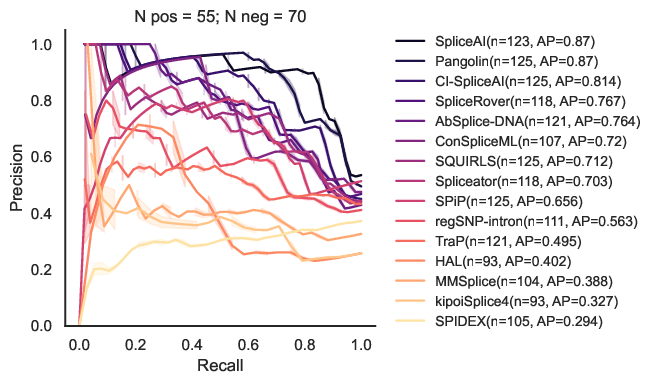

In [74]:
! cp out/out_partial_ir_donor_downstream/tools_benchmark/all_types/results_tsv/statistics_all_types_all.tsv data/splicing_altering/per_category/partial_intron_retention/donor_downstream/
perf="out/out_partial_ir_donor_downstream/tools_benchmark/all_types/roc_analysis/ROC_pr_all.pdf"
img = WImage(filename=perf, resolution=100)
img

# **Evaluating interpretability of SPiP and SQUIRLS and tissue-specificity of AbSplice-DNA**

#### *Analysis for Figure 4, Supplementary Figure 7 and Supplementary Figure 8*

### Interpretability

We will inspect whether tools that take interpretability into account provide accurate hints when predicting correctly a splicing defect. First, we will check which variants SQUIRLS and SPiP predict correctly in the splicing pathogenic dataset.

In [75]:
cmd = "veta interrogate --out_dir out/out_inspect_interpretability \
    --types_of_variant all_types \
    --metric weighted_accuracy \
    --label Pathogenic \
    --plot_these_tools SQUIRLS SPiP \
    --top_vep_consequence smallest_offset \
    --config data/splicing_pathogenic_manual_curation/2_interpretability/tools_config.txt \
    data/splicing_pathogenic_manual_curation/pathogenic.vcf.gz" 

args = shlex.split(cmd)

with open('out/log_inspect_interpretability.txt', 'w') as f:
    subprocess.run(args,stderr=f, stdout=f, check=True)

We ran again SQUIRLS for the subset of variants predicted correctly by generating output in HTML. Then, we manually curated the interpretations provided by SQUIRLS, and run the R script `6_evaluate_SPiP_and_SQUIRLS_explanations.R` within the `scripts` directory. This script automatically processed SPiP and SQUIRLS interpretations to generate final plots. 

### AbSplice-DNA

In addition, we aimed to study how well AbSplice-DNA predicts tissue specificity. From the manually curated dataset (ours plus VazDrago et al.,2017) of pathogenic variants, we collected the closest GTEx tissues that the disease affects, according to the human phenotype ontology. Our goal was to evaluate whether AbSplice-DNA gives higher scores for those tissues where the variant is relevant. We check which variants AbSplice-DNA predicts correctly with:

In [76]:
cmd = "veta interrogate --out_dir out/out_inspect_tissue_specificity \
    --types_of_variant all_types \
    --metric weighted_accuracy \
    --label Pathogenic \
    --plot_these_tools AbSplice-DNA \
    --top_vep_consequence smallest_offset \
    --config data/splicing_pathogenic_manual_curation/3_tissue_specificity/tools_config.txt \
    data/splicing_pathogenic_manual_curation/pathogenic.vcf.gz"

args = shlex.split(cmd)

with open('out/log_inspect_tissue_specificity.txt', 'w') as f:
    subprocess.run(args,stderr=f, stdout=f, check=True)